# Configure Capacity With Nodes and Layers

The capacity of a deep learning neural network model controls the scope of the mapping functions that it is able to learn. A model with too little capacity cannot learn the training dataset meaning it will underfitt, whereas a model with too much capacity may memorize the training dataset, meaning it will overfit or may get stuck or lost during the optimization process. The capacity of a neural network model is defined by configuring the number of nodes and the number of layers. In this tutorial, you will discover how to control the capacity of a neural network model and how capacity impacts what a model is capable of learning. After completing this tutorial, you will know:

* Neural network model capacity is controlled by the number of nodes and the number of layers in the model.
* A model with a single hidden layer and a sufficient number of nodes can learn any mapping function. Still, the chosen learning algorithm may or may not be able to realize this capability.
* Increasing the number of layers provides a shortcut to increasing the model's capacity with fewer resources, and modern techniques allow learning algorithms to successfully train deep models.

## Neural Network Model Capacity

The goal of a neural network is to learn how to map input examples to output examples. Neural networks learn mapping functions. The capacity of a network refers to the range or scope of the functions that the model can approximate.

A model with less capacity may not be able to sufficiently learn the training dataset. A model with more capacity can model more different functions and may be able to learn a function to sufficiently map inputs to outputs in the training dataset. Whereas a model with too much capacity may memorize the training dataset and fail to generalize or get lost or stuck searching for a suitable mapping function. Generally, we can think of model capacity as control over whether the model is likely to underfit or overfit a training dataset.

The capacity of a neural network can be controlled by two aspects of the model:
* Number of Nodes.
* Number of Layers.

A model with more nodes or more layers has a greater capacity and, in turn, is potentially capable of navigating a larger set of mapping functions.

Traditionally, it has been challenging to train neural network models with more than a few layers due to vanishing gradients. More recently, modern methods have allowed deep network models to develop, allowing the development of surprising depth models capable of achieving impressive performance on challenging problems in a wide range of domains.

## Model Capacity Case Study

This section will demonstrate how to use the model capacity to control learning with an MLP on a simple classification problem. This example provides a template for exploring model capacity with your own neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a standard multiclass classification problem as the basis to demonstrate the effect of model capacity on model performance. The scikit-learn class provides the make_blobs() function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We can configure the problem to have a specific number of input variables via the `n_features` argument and a specific number of classes or centers via the `centers` argument. The `random_state` can seed the pseudorandom number generator to ensure that we always get the same samples each time the function is called. For example, the call below generates 1,000 examples for a three-class problem with two input variables.

```
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, 
                  centers=3, 
                  n_features=2, 
                  cluster_std=2, 
                  random_state=2)
```               

The results are the input and output elements of a dataset that we can model. To get a feeling for the complexity of the problem, we can plot each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

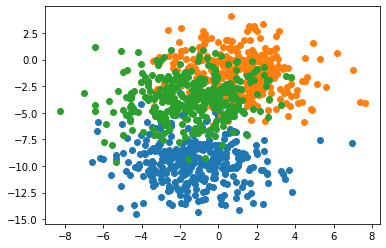

In [1]:
import numpy
import os
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# fix random seed for reproducibility
seed = 2

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
numpy.random.seed(seed)
tf.random.set_seed(seed)

# scatter plot of blobs dataset
from numpy import where
from sklearn.datasets import make_blobs
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)
    
    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

    # show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset (above). We can see that the chosen standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different good enough candidate solutions.

To explore model capacity, we need more complexity in the problem than three classes and two variables. For the purposes of the following experiments, we will use 100 input features and 20 classes; for example:

```
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, 
                  centers=20, 
                  n_features=100, 
                  cluster_std=2, 
                  random_state=seed)
```

### Change Model Capacity With Nodes

In this section, we will develop a Multilayer Perceptron model, or MLP, for the blobs multiclass classification problem and demonstrate the effect that the number of nodes has on the model's ability to learn. We can start off by developing a function to prepare the dataset. The input and output elements of the dataset can be created using the `make_blobs()` function as described in the previous section. Next, the target variable must be one-hot encoded. This is so that the model can learn to predict the probability of an input example belonging to each of the 20 classes. We can use the `to_categorical()` Keras utility function to do this, for example:

```
# one hot encode output variable
y = to_categorical(y)
```

Next, we can split the 1,000 examples in half and use 500 examples as the training dataset and 500 to evaluate the model.

```
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
return trainX, trainy, testX, testy
```

The `create_dataset()` function below ties these elements together and returns the train and test sets in terms of the input and output elements.

In [2]:
#Plot of images as baseline for comparison
from tensorflow.keras.utils import to_categorical

# prepare multiclass classification dataset
def create_dataset():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=20, n_features=100, cluster_std=2, random_state=seed)
    
    # one hot encode output variable
    y = to_categorical(y)
    
    # split into train and test
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    
    return trainX, trainy, testX, testy

We can call this function to prepare the dataset.

In [3]:
# prepare dataset
trainX, trainy, testX, testy = create_dataset()

Next, we can define a function that will create the model, fit it on the training dataset, and then evaluate it on the test dataset. The model needs to know the number of input variables to configure the input layer and the number of target classes to configure the output layer. These properties can be extracted from the training dataset directly.

```
# configure the model based on the data
n_input, n_classes = trainX.shape[1], testy.shape[1]
```

We will define an MLP model with a single hidden layer that uses the rectified linear activation function and the He random weight initialization method. The output layer will use the softmax activation function to predict a probability for each target class. The number of nodes in the hidden layer will be provided via an argument called `n_nodes`.

```
# define model
model = Sequential()
model.add(Dense(n_nodes, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(n_classes, activation='softmax'))
```

The model will be optimized using stochastic gradient descent with a modest learning rate of 0.01 with a high momentum of 0.9, and a categorical cross-entropy loss function will be used, suitable for multiclass classification.

```
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics['accuracy'])
```

The model will be fit for 100 training epochs, then the model will be evaluated on the test dataset.

```
# fit model on train set
history = model.fit(trainX, trainy, epochs=100, verbose=0)
# evaluate model on test set
_, test_acc = model.evaluate(testX, testy, verbose=0)
```

Tying these elements together, the `evaluate_model()` function below takes the number of nodes and dataset as arguments and returns the history of the training loss at the end of each epoch and the accuracy of the final model on the test dataset.

In [4]:
# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_nodes, trainX, trainy, testX, testy):
    # configure the model based on the data
    n_input, n_classes = trainX.shape[1], testy.shape[1]

    # define model
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(n_classes, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model on train set
    history = model.fit(trainX, trainy, epochs=100, verbose=0)

    # evaluate model on test set
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return history, test_acc

We can call this function with different numbers of nodes to use in the hidden layer. The problem is relatively simple; therefore, we will review the model's performance with 1 to 7 nodes. We would expect that increasing the number of nodes would increase the model's capacity and allow the model to better learn the training dataset, at least to a point limited by the chosen configuration for the learning algorithm (e.g., learning rate, batch size, batch size, and epochs). The test accuracy for each configuration will be printed, and the learning curves of training accuracy with each configuration will be plotted.

nodes=1: 0.138
nodes=2: 0.364
nodes=3: 0.628
nodes=4: 0.894
nodes=5: 0.886
nodes=6: 1.000
nodes=7: 1.000


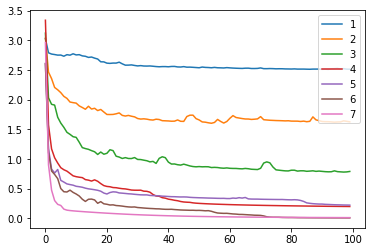

In [5]:
# evaluate model and plot learning curve with given number of nodes
num_nodes = [1, 2, 3, 4, 5, 6, 7]

for n_nodes in num_nodes:
    # evaluate model with a given number of nodes
    history, result = evaluate_model(n_nodes, trainX, trainy, testX, testy)
    
    # summarize final test set accuracy
    print('nodes=%d: %.3f' % (n_nodes, result))

    # plot learning curve
    pyplot.plot(history.history['loss'], label=str(n_nodes))

# show the plot
pyplot.legend()
pyplot.show()

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that as the number of nodes increases, the model's capacity to learn the problem is increased. This results in a progressive lowering of the model's generalization error on the test dataset until 6 and 7 nodes when the model learns the problem perfectly.

A line plot is also created showing cross-entropy loss on the training dataset for each model configuration (1 to 7 nodes in the hidden layer) over the 100 training epochs. As the number of nodes increases, the model can better decrease the loss, e.g., to better learn the training dataset. This plot shows the direct relationship between model capacity, as defined by the number of nodes in the hidden layer, and the model's ability to learn.

The number of nodes can be increased to the point (e.g., 1,000 nodes) where the learning algorithm is no longer able to sufficiently learn the mapping function.

### Change Model Capacity With Layers

We can perform a similar analysis and evaluate how the number of layers impacts the ability of the model to learn the mapping function. Increasing the number of layers can often greatly increase the model's capacity, acting like a computational and learning shortcut to modeling a problem. For example, a model with one hidden layer of 10 nodes is not equivalent to a model with two hidden layers with five nodes each. The latter has a much greater capacity. The danger is that a model with more capacity than is required is likely to overfit the training data, and as with a model that has too many nodes, a model with too many layers will likely be unable to learn the training dataset, getting lost or stuck during the optimization process. 

First, we can update the `evaluate_model()` function to fit an MLP model with a given number of layers. We know from the previous section that an MLP with about seven or more nodes fit for 100 epochs will learn the problem perfectly. We will, therefore, use 10 nodes in each layer to ensure the model has enough capacity in just one layer to learn the problem. The updated function is listed below, taking the number of layers and dataset as arguments and returning the model's training history and test accuracy.

In [6]:
# fit model with given number of layers, returns test set accuracy
def evaluate_model(n_layers, trainX, trainy, testX, testy):
    # configure the model based on the data
    n_input, n_classes = trainX.shape[1], testy.shape[1]

    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
    
    for _ in range(1, n_layers):
        model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(n_classes, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model

    history = model.fit(trainX, trainy, epochs=100, verbose=0)

    # evaluate model on test set
    _, test_acc = model.evaluate(testX, testy, verbose=0)

    return history, test_acc

Given that a single hidden layer model has enough capacity to learn this problem, we will explore increasing the number of layers to the point where the learning algorithm becomes unstable and can no longer learn the problem. If the chosen modeling problem was more complex, we could explore increasing the layers and review the improvements in model performance to the point of diminishing returns. In this case, we will evaluate the model with 1 to 5 layers, with the expectation that at some point, the number of layers will result in a model that the chosen learning algorithm is unable to adapt to the training data.

layers=1: 1.000
layers=2: 0.954
layers=3: 0.986
layers=4: 0.994
layers=5: 0.582


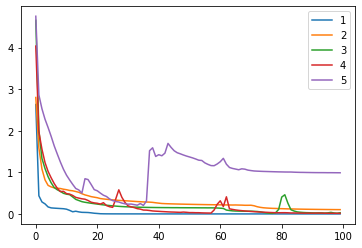

In [7]:
# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [1, 2, 3, 4, 5]

for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, trainX, trainy, testX, testy)
    print('layers=%d: %.3f' % (n_layers, result))

    # plot learning curve
    pyplot.plot(history.history['loss'], label=str(n_layers))

pyplot.legend()
pyplot.show()

Running the example first prints the test accuracy for each model configuration.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model can learn the problem well with up to three layers and then begins to falter. We can see that performance really drops with five layers and is expected to continue to fall if the number of layers is increased further.

A line plot is also created showing cross-entropy loss on the training dataset for each model configuration (1 to 5 layers) over the 100 training epochs. We can see that the dynamics of the model with 1, 2, and 3 models (blue, orange, and green) are pretty similar, learning the problem quickly. Surprisingly, training loss with four and five layers shows signs of initially doing well, then leaping up, suggesting that the model is likely stuck with a sub-optimal set of weights rather than overfitting the training dataset.

The analysis shows that increasing the model's capacity via increasing depth is a very effective tool that must be used with caution as it can quickly result in a model with a large capacity that may not be capable of learning the training dataset easily.

**Extensions**

This section lists some ideas for extending the tutorial that you may wish to explore.
* **Too Many Nodes**. Update the experiment of increasing nodes to find the point where the learning algorithm can no longer learn the problem.
* **Repeated Evaluation**. Update an experiment to use the repeated evaluation of each configuration to counter the stochastic nature of the learning algorithm.
* **Harder Problem**. Repeat the experiment of increasing layers on a problem that requires the increased capacity provided by increased depth to perform well.

**Summary**

In this tutorial, you discovered how to control the capacity of a neural network model and how capacity impacts what a model is capable of learning. Specifically, you learned:
* Neural network model capacity is controlled by the number of nodes and the number of layers in the model.
* A model with a single hidden layer and a sufficient number of nodes has the capability of learning any mapping function, but the chosen learning algorithm may or may not be able to realize this capability.
* Increasing the number of layers provides a shortcut to increasing the model's capacity with fewer resources, and modern techniques allow learning algorithms to successfully train deep models.